# Pneumonia Detection Using X-Ray Images

## Introduction

X-rays allow us to detect signs of pneumonia and confirm the diagnosis, identify the type, and stage of the disease. Compared to other diagnostic methods, X-rays are more accessible while maintaining effectiveness. However, since pneumonia and other lung diseases have similar appearances on X-rays, this diagnostic method is only a part of a comprehensive examination.

### What does a specialist look for to make a diagnosis?

- The shape and size of the lung fields (normal or abnormalities).
- Transparency of lung fields or abnormalities such as:
  - Shadows
  - Bright spots
  - Mixed shadow symptoms
- The lung pattern (enhanced, reduced, or normal).

Unlike specialists, the neural model does not need detailed X-ray reviews. The diagnosis will be provided instantly. However, first, we need to build and train the model. The backbone of our model is **ResNet50**, capable of handling tasks much more complex than ours.

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
from tqdm import tqdm 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dropout, MaxPooling2D, Dense, Conv2D, Activation, Flatten
from keras.applications import ResNet50V2
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")


In [4]:
class_names = ['NORMAL', 'PNEUMONIA']
nb_classes = len(class_names)
image_size = (220, 220)


## Load Dataset



In [5]:
def load_data():
    datasets = ['/kaggle/input/chest-xray-pneumonia/chest_xray/train',
                '/kaggle/input/chest-xray-pneumonia/chest_xray/test']
    images = []
    labels = []

    for dataset in datasets:
        for folder in os.listdir(dataset):
            if folder in ['NORMAL']: label = 0
            elif folder in ['PNEUMONIA']: label = 1

            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                img_path = os.path.join(os.path.join(dataset, folder), file)
                image = cv2.imread(img_path)
                try:
                    image = cv2.resize(image, image_size, interpolation=cv2.INTER_AREA)
                except:
                    continue
                images.append(image)
                labels.append(label)

    images = np.array(images, dtype='float32')
    labels = np.array(labels, dtype='int32')
    return images, labels

images, labels = load_data()


100%|██████████| 234/234 [00:05<00:00, 39.30it/s]


## Split data

In [8]:
images, labels = shuffle(images, labels, random_state=10)

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.23)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size=0.5)

print(f"Training samples: {len(train_labels)}")
print(f"Validation samples: {len(val_labels)}")
print(f"Testing samples: {len(test_labels)}")


Training samples: 4496
Validation samples: 672
Testing samples: 672


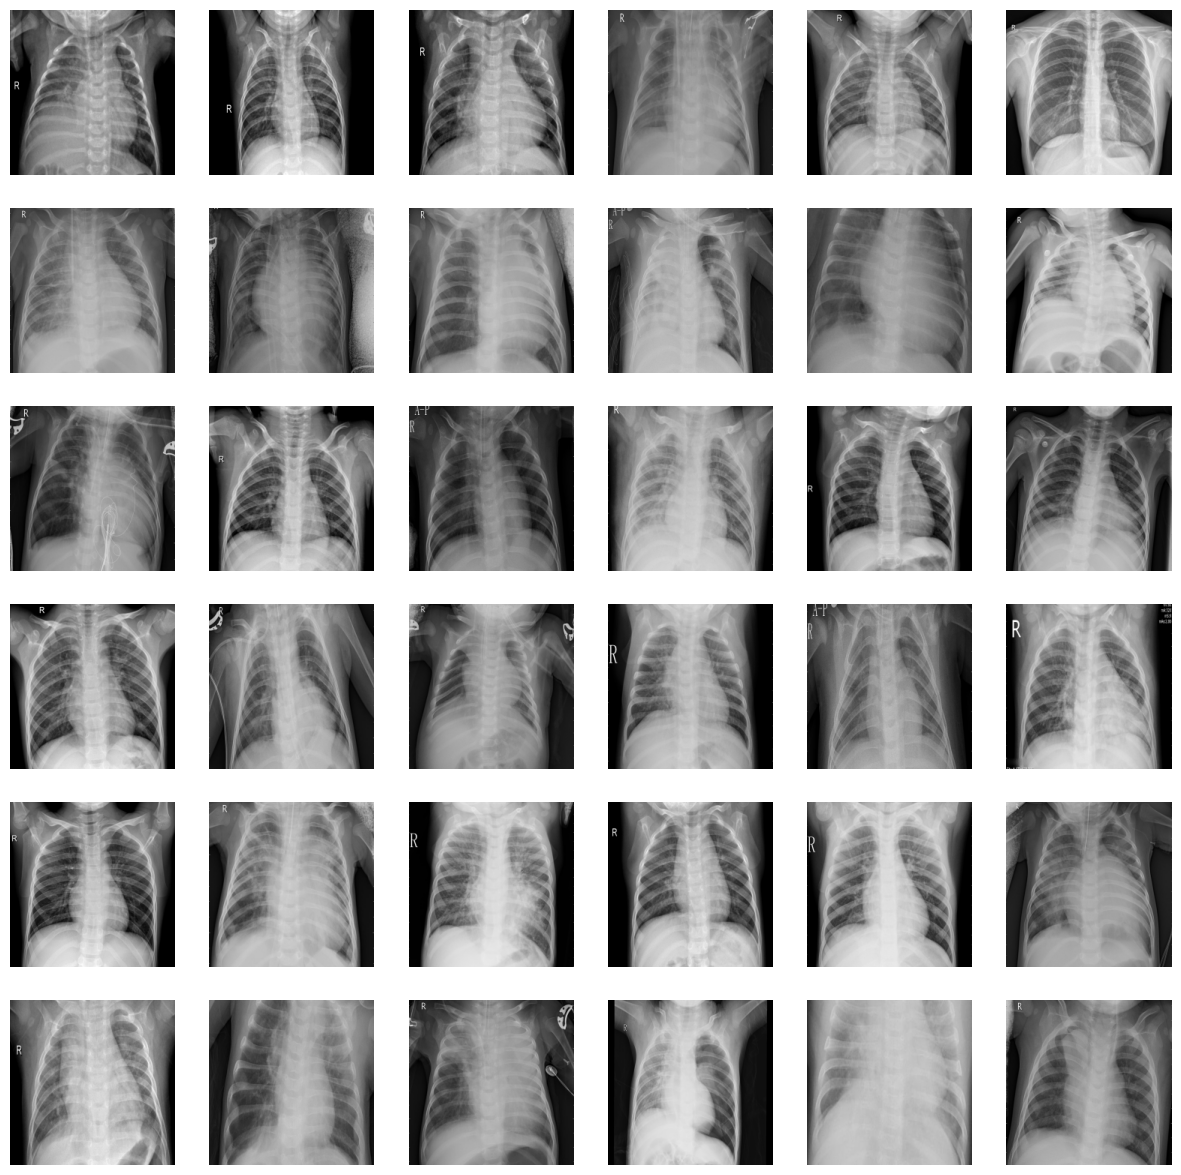

In [9]:
train_images = train_images / 255.0
val_images = val_images / 255.0
test_images = test_images / 255.0
plt.figure(figsize=(15, 15))
for n, i in enumerate(np.random.randint(0, len(train_images), 36)):
    plt.subplot(6, 6, n + 1)
    plt.imshow(train_images[i])
    plt.axis("off")
plt.show()


## model training


In [10]:
resnet50 = ResNet50V2(weights="imagenet", input_shape=(220, 220, 3), include_top=False)
model = Sequential()
model.add(resnet50)

for layer in resnet50.layers:
    layer.trainable = False

model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()
history = model.fit(
    train_images, train_labels,
    batch_size=16,
    epochs=10,
    validation_data=(val_images, val_labels)
)


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ ?                      │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/10


I0000 00:00:1733895692.060856      75 service.cc:145] XLA service 0x790ed001e4a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733895692.060943      75 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733895692.060950      75 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  5/281 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.4717 - loss: 4.9414

I0000 00:00:1733895699.102757      75 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


281/281 ━━━━━━━━━━━━━━━━━━━━ 28s 56ms/step - accuracy: 0.8855 - loss: 1.4938 - val_accuracy: 0.9494 - val_loss: 0.1824
Epoch 2/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.9409 - loss: 0.1872 - val_accuracy: 0.9315 - val_loss: 0.2156
Epoch 3/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9574 - loss: 0.1210 - val_accuracy: 0.9598 - val_loss: 0.1053
Epoch 4/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9677 - loss: 0.1022 - val_accuracy: 0.9568 - val_loss: 0.1154
Epoch 5/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9685 - loss: 0.0755 - val_accuracy: 0.9539 - val_loss: 0.1479
Epoch 6/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9678 - loss: 0.0929 - val_accuracy: 0.9583 - val_loss: 0.1788
Epoch 7/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9761 - loss: 0.0591 - val_accuracy: 0.9568 - val_loss: 0.1608
Epoch 8/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.9808 - loss: 0.0459 - val_accurac

In [12]:
scores = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {scores[1] * 100:.2f}%")


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.9642 - loss: 0.1667
Test Accuracy: 95.83%


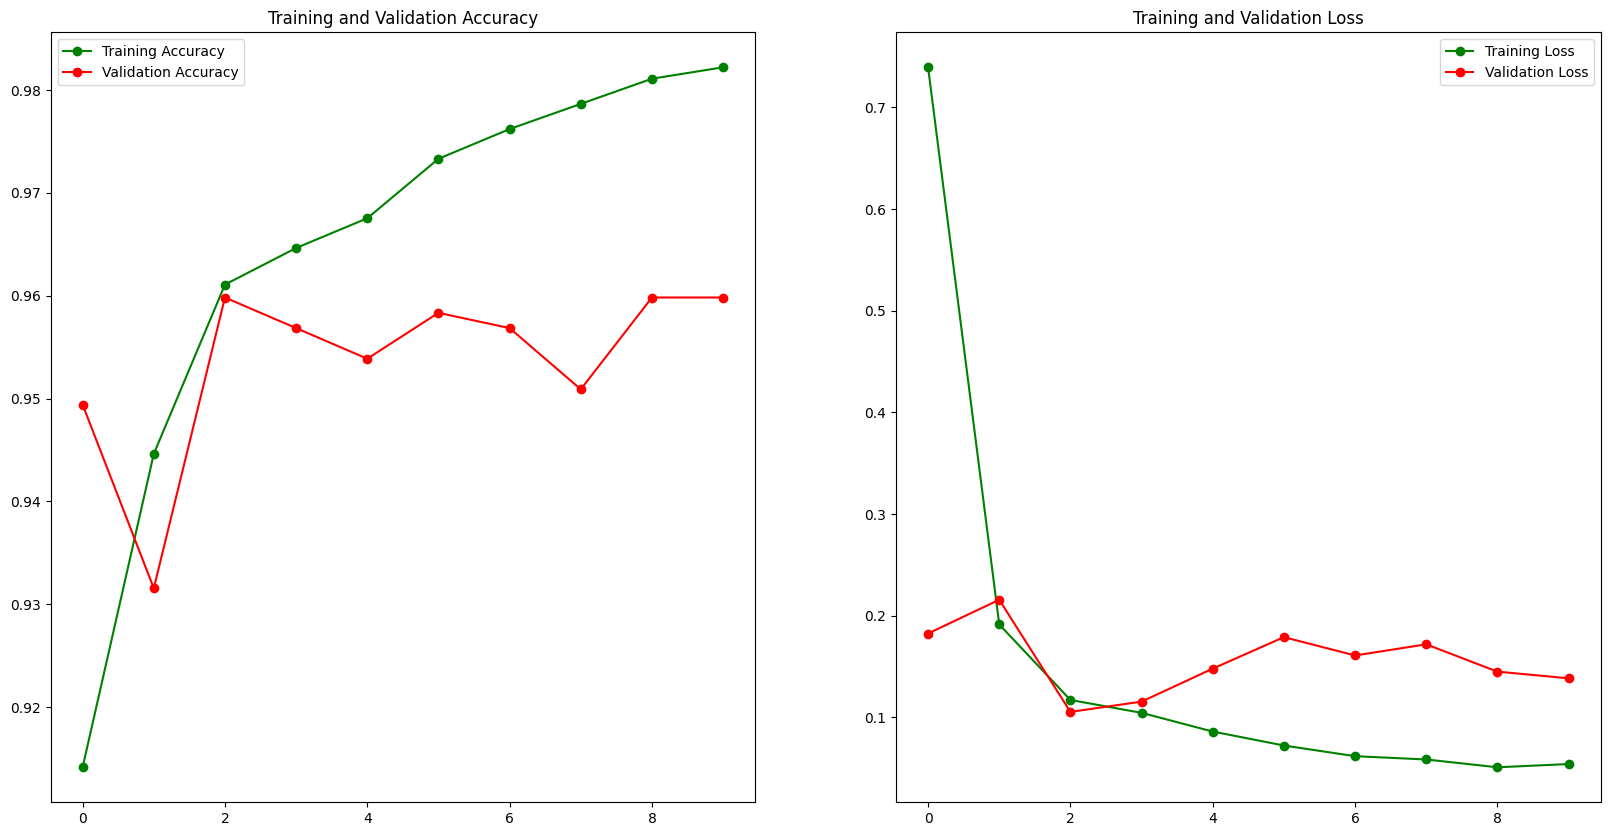

In [13]:
epochs = range(10)
plt.figure(figsize=(20, 10))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], 'go-', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], 'g-o', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'r-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step


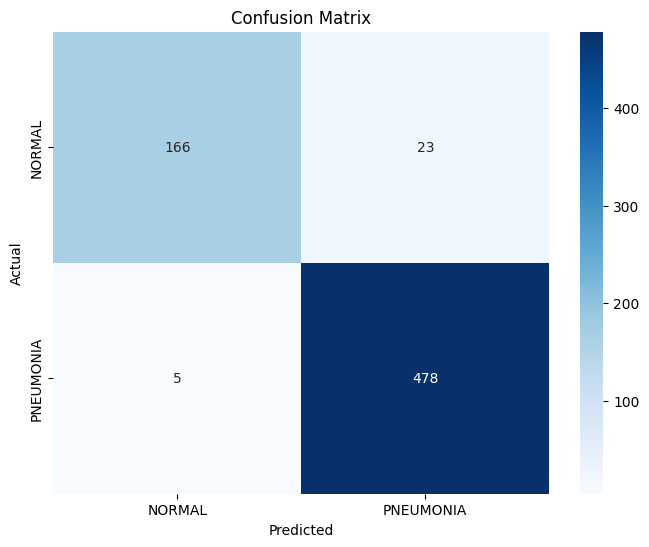

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.97      0.88      0.92       189
   PNEUMONIA       0.95      0.99      0.97       483

    accuracy                           0.96       672
   macro avg       0.96      0.93      0.95       672
weighted avg       0.96      0.96      0.96       672



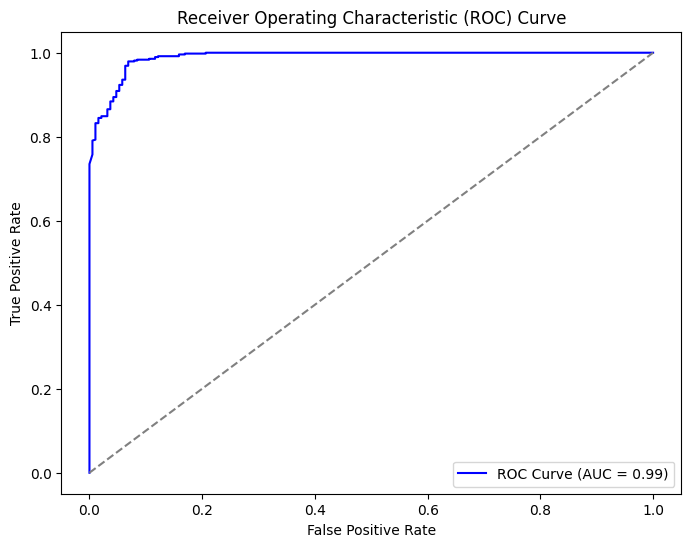

In [14]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on the test dataset
y_pred = model.predict(test_images)
y_pred_classes = np.round(y_pred).astype(int)  # Convert predictions to binary classes (0 or 1)

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, y_pred_classes)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(test_labels, y_pred_classes, target_names=class_names))

# ROC Curve
fpr, tpr, thresholds = roc_curve(test_labels, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step
True Class: PNEUMONIA
Predicted Class: PNEUMONIA


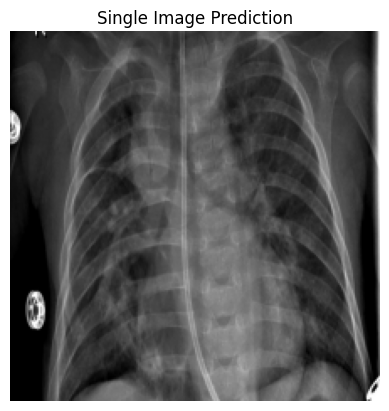

In [15]:
first_image = test_images[0]
first_label = test_labels[0]

plt.title("Single Image Prediction")
plt.imshow(first_image)
plt.axis("off")

predictions = model.predict(test_images)
print(f"True Class: {class_names[first_label]}")
print(f"Predicted Class: {class_names[int(np.round(predictions[0]))]}")
